### This notebook is for getting the predicted bounding boxes and which can be used o get the evaluation metrics

In [1]:
""" This module is for prediction. """
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
#  imports from the object detection module.
# sys.path.append("..")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# glob finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
import glob 

In [2]:
# What model to download.
MODEL_NAME = '/home/ubuntu/data/tensorflow/my_workspace/training_demo/trained-inference-graphs/output_inference_graph'#'ssd_mobilenet_v1_coco_2017_11_17'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/', 'label_map.pbtxt')
NUM_CLASSES = 46

PATH_TO_TEST_IMAGES_DIR = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/test_images'
TEST_IMAGE_PATHS = glob.glob('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/test_images/*.jpg')
# [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 9) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 12)

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [4]:
def load_label_map(PATH_TO_LABELS, NUM_CLASSES):
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return label_map, categories, category_index


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
            'num_detections', 'detection_boxes', 'detection_scores',
            'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                    tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.1), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                    'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


def get_per_image_prediction(output_dict, image, threshold_detection_score=0.5):
    image_np = load_image_into_numpy_array(image)
    label_map, categories, category_index = load_label_map(PATH_TO_LABELS, NUM_CLASSES)
    width = image_np.shape[1]  # Number of columns
    height = image_np.shape[0]  # number of rows
    category_index = label_map_util.create_category_index(categories)
    image_bb_list = []

    for i in range(len(output_dict['detection_boxes'])):
        bb_prediction = {}
        if output_dict['detection_scores'][i] > threshold_detection_score:
            image_bb_list.append({'class_name':category_index[output_dict['detection_classes'][i]]['name'], \
                                 'detection_scores': str(output_dict['detection_scores'][i]),\
                                 'detection_classes': (output_dict['detection_classes'][i]), \
                                 'bb_xmin': str(int(width * output_dict['detection_boxes'][i][1])),\
                                 'bb_ymin': str(int(height * output_dict['detection_boxes'][i][0])), \
                                 'bb_xmax': str(int(width * output_dict['detection_boxes'][i][3])),\
                                 'bb_ymax': str(int(height * output_dict['detection_boxes'][i][2])),
                                 'width': str(width),\
                                 'height': str(height)
                                 })
    
    return image_bb_list


In [5]:
TEST_IMAGE_PATHS = glob.glob('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Data/images/test/*.jpg')

In [15]:
image_bb_prediction = {}
i = 0
for image_path in TEST_IMAGE_PATHS:
    i = i+1
    filename = os.path.split(os.path.split(image_path)[1])[1]
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    image_bb_list = get_per_image_prediction(output_dict, image, threshold_detection_score=0.5)
    image_bb_prediction[filename] = image_bb_list
    print('processessed image: %d' % i)

processessed image: 1
processessed image: 2
processessed image: 3
processessed image: 4
processessed image: 5
processessed image: 6
processessed image: 7
processessed image: 8
processessed image: 9
processessed image: 10


In [12]:
image_bb_prediction

{'ASG000bgqu.jpg': [{'bb_xmax': 794,
   'bb_xmin': 538,
   'bb_ymax': 846,
   'bb_ymin': 631,
   'class_name': 'Wildebeest',
   'detection_classes': 1,
   'detection_scores': '0.9899088',
   'height': 1536,
   'width': 2048},
  {'bb_xmax': 526,
   'bb_xmin': 376,
   'bb_ymax': 765,
   'bb_ymin': 684,
   'class_name': 'Wildebeest',
   'detection_classes': 1,
   'detection_scores': '0.936362',
   'height': 1536,
   'width': 2048},
  {'bb_xmax': 1007,
   'bb_xmin': 843,
   'bb_ymax': 767,
   'bb_ymin': 663,
   'class_name': 'Zebra',
   'detection_classes': 2,
   'detection_scores': '0.8179927',
   'height': 1536,
   'width': 2048},
  {'bb_xmax': 540,
   'bb_xmin': 421,
   'bb_ymax': 751,
   'bb_ymin': 686,
   'class_name': 'Wildebeest',
   'detection_classes': 1,
   'detection_scores': '0.783428',
   'height': 1536,
   'width': 2048},
  {'bb_xmax': 226,
   'bb_xmin': 162,
   'bb_ymax': 675,
   'bb_ymin': 625,
   'class_name': 'Wildebeest',
   'detection_classes': 1,
   'detection_scores':

In [ ]:
# import json
import json as json
# Saving to json
with open('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_data_50pct.json', 'w') as outfile:
    json.dump(image_bb_prediction, outfile)

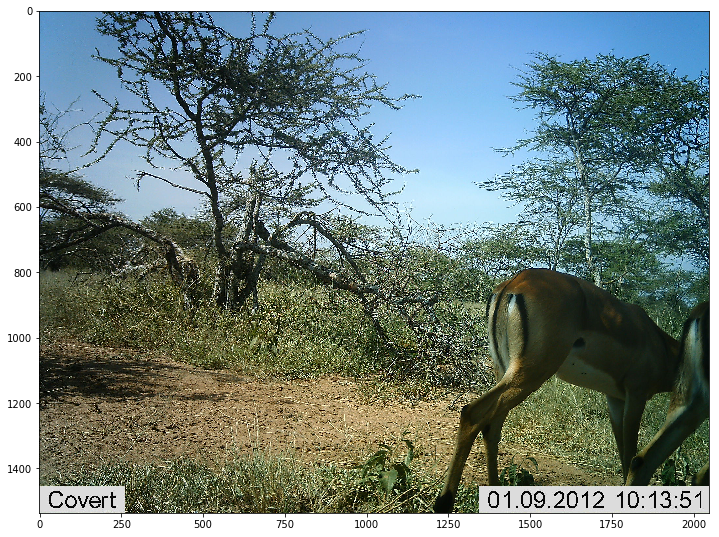

In [36]:
IMAGE_SIZE = (12, 18)
image = Image.open('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Data/images/test/ASG000by6r.jpg')
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)